In [1]:
import warnings
from bs4 import BeautifulSoup
import pandas as pd
from pandas import DataFrame, read_csv
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle, islice
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt



This file contains the first 'most relevant' 100 reviews for each app. 

Each review text/comment has been pre-processed and attributed with 3 new features - Sentiment, Sentiment Polarity and Sentiment Subjectivity.


In [2]:
data = pd.read_csv('googleplaystore_user_reviews.csv')
#len(data.index) #64295
data['Sentiment_Polarity'] = data['Sentiment_Polarity'].apply(lambda x: float(x))
data.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [3]:
#About 42% of this data is null, so i had to remove all non relevant data.
data=data.dropna() #remove row that have no data (NaN's)
#len(data.index) #37427 --> after removing all nulls
data.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


# Polarity? Subjectivity?
What are those?


**Polarity**


It simply means *emotions expressed in a sentence.*
Emotions are closely related to sentiments. The strength of a sentiment or opinion is typically linked to the intensity of certain emotions, like joy and anger.
Opinions in sentiment analysis are mostly evaluations(although not always).

According to consumer behavior research, evaluations can be broadly categorized into two types:
1. Rational evaluations
2. Emotional evaluations.
Rational evaluation: Such evaluations are from rational reasoning, tangible beliefs, and utilitarian attitudes. For example, the following sentences
Express rational evaluations: “The voice of this phone is clear,” “This car is worth the price,” and “I am happy with this car.”
Emotional evaluation: Such evaluations are from non-tangible and emotional responses to entities which go deep into people’s state of mind.

For example, the following sentences express emotional evaluations: “I love iPhone,” “I am so angry with their service people” and “This is the best car ever built.”


**To make use of these two types of evaluations in practice, we can design 5 sentiment ratings, emotional negative (-2), rational negative (-1), neutral (0), rational positive (+1), and emotional positive (+2). In practice, neutral often means no opinion or sentiment expressed.**


**Subjectivity**

*Subjective sentence expresses some personal feelings, views, or beliefs.*

An example: 
subjective sentence is “I like iPhone.” Subjective expressions come in many forms, e.g., opinions, allegations, desires, beliefs, suspicions, and speculations.

A subjective sentence may not express any sentiment.
For example, “I think that he went home” and “I want a camera that can take good photos” are a subjective sentences, but does not express any sentiment.

(Source: Bing Liu. Sentiment Analysis and Opinion Mining, Morgan & Claypool Publishers, May 2012)

- So, we want to categorize the data, First we need to understand how to make connection between the Polarity and Subjectivity.
Polarity in ranked from -1 to 1, and Subjectivity from 0 to 1.
lets take some examples from data and check how we make the connection:

In [4]:
#I chose 10 reviews that have all range of sentiments
data[6948:6949]

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
10826,BET NOW - Watch Shows,HATED IT,Negative,-0.9,0.7


The review "HATED IT" is easily classified as Negative, and we can see that it's very subjective because the reviewer said that **he** hated it, thats why the Sentiment_Subjectivity is 0.7 (pretty high).
In the Polarity test he got -0.9 which is pretty low but still it's rational when user install a game/App and hate it.


In [5]:
#Lets check the Airbnb application, which (also personally) gives mixed emotion.
data.loc[(data.Sentiment_Polarity <=-0.5)& (data.App == 'Airbnb') ]

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
4987,Airbnb,"Idk why, newer updates made SO difficult use. ...",Negative,-0.738281,0.95
5072,Airbnb,"Useless, allow login keeps asking send comment...",Negative,-0.500000,0.20


4987 - "Idk why, newer updates made SO difficult use. When I try tap listing view it, map shift somewhere else pull listings. So frustrating!!!!" 

5072 - "Useless, allow login keeps asking send comment. Tried reinstalling twice."

- Polarity test shows that those reviews is Emotionally Negative, The first review is Subjectivity high! (0.95), because it was "frustrating" for him when he installed and used this app, And in the second reviews we see that he/she just gives raw facts about the installtion and using this app.

In [6]:
data.loc[(data.Sentiment_Polarity>= 0.4 )& (data.App == 'Airbnb') ]

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
4982,Airbnb,Love hosting airBnB. The overall good. However...,Positive,0.520000,0.590000
5005,Airbnb,I like easy host travel mode... Just wish coul...,Positive,0.433333,0.833333
5022,Airbnb,Love hosting airBnB. The overall good. However...,Positive,0.520000,0.590000
5047,Airbnb,I like easy host travel mode... Just wish coul...,Positive,0.433333,0.833333
5060,Airbnb,"Thank you providing us great ota, really helps...",Positive,0.500000,0.475000
5064,Airbnb,"Used Airbnb first time, stay, room, host fanta...",Positive,0.483333,0.661111
5084,Airbnb,"A great app! It is ideal for travel hosts, tha...",Positive,0.542708,0.658333


**5084** - *"A great app! It is ideal for travel hosts, thanks Airbnb managed to travel unique sites earn extra money by renting my space. The staff at Airbnb is fantastic !!!"* - As we see very positive review, and subjectively also hige because he is renting his space.(0.66)

**5005** - *"I like easy host travel mode... Just wish could search properties based listed name"* - Also very high subjectively (0.83) because he liked the easiness of the use, but give rather not high Polarity score because he also say the app is not perfect, he offers them to add some functionality.

- From this examples we can **Sub-Categorize** all the data:
- 'Emotionally Negative' -> Sentiment_Polarity less than -0.1, Sentiment_Subjectivity more than 0.33.
- 'Rationally Negative' -> Sentiment_Polarity less than 0 , but the Sentiment_Subjectivity less than 0.33
- 'Neutral' -> Sentiment_Polarity is 0 and Sentiment_Subjectivity is less than 0.5. (very subjective is not Neutral)
- 'Rationally Positive' -> Sentiment_Polarity more than 0 (or equal) and the Sentiment_Subjectivity less than 0.33 (third)
- 'Emotionally Positive' -> More than 0.1 (Polarity), and Sentiment_Subjectivity more than 0.33.
- 'Cannot Be Evaluated' -> All the rest

My assumption to the reviews, Emotionally Positive/Negative must have Sentiment_Subjectivity score more than 0.33

In [7]:
data['Category'] = np.nan
data.loc[ (data.Sentiment_Polarity <=1) & (data.Sentiment_Subjectivity <=1),'Category']='Cannot Be Evaluated' #all the rest
data.loc[(data.Sentiment_Polarity >=0.1) & (data.Sentiment_Subjectivity >=0.33),'Category'] = 'Emotionally Positive'
data.loc[(data.Sentiment_Polarity >=0) & (data.Sentiment_Subjectivity <=0.33),'Category' ] = 'Rationally Positive'
data.loc[(data.Sentiment_Polarity == 0) & (data.Sentiment_Subjectivity <=0.50),'Category' ] = 'Neutral'
data.loc[(data.Sentiment_Polarity <0) & (data.Sentiment_Subjectivity <=0.34),'Category' ] = 'Rationally Negative'
data.loc[(data.Sentiment_Polarity <=-0.1) & (data.Sentiment_Subjectivity >=0.33),'Category' ] = 'Emotionally Negative'
data.Category.value_counts() #all of them categorized

Emotionally Positive    18849
Emotionally Negative     5002
Neutral                  4869
Cannot Be Evaluated      4794
Rationally Positive      2542
Rationally Negative      1371
Name: Category, dtype: int64

In [8]:
x = data['Category'].value_counts()
#x.sum() 37427
print('Precentage (%):\n', (x / x.sum()).round(3)) #Distribution of sub-Categories

Precentage (%):
 Emotionally Positive    0.504
Emotionally Negative    0.134
Neutral                 0.130
Cannot Be Evaluated     0.128
Rationally Positive     0.068
Rationally Negative     0.037
Name: Category, dtype: float64


Text(0.5, 1.0, 'Sub-Categories')

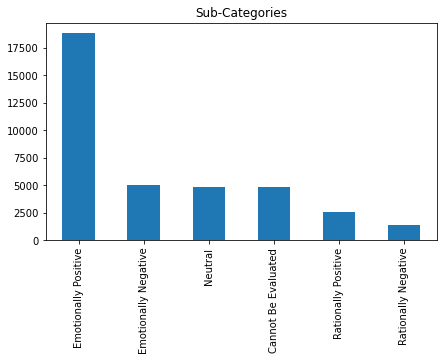

In [9]:
plt.figure(figsize=(7,4))
temp = x
temp.plot.bar()
plt.title("Sub-Categories")

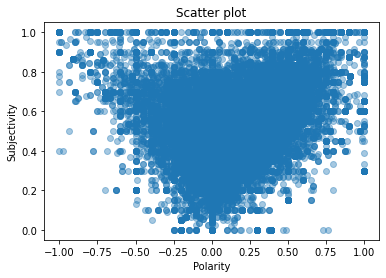

In [10]:
# Plot
plt.scatter(x=data.Sentiment_Polarity, y=data.Sentiment_Subjectivity, alpha=0.4)

plt.title('Scatter plot')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

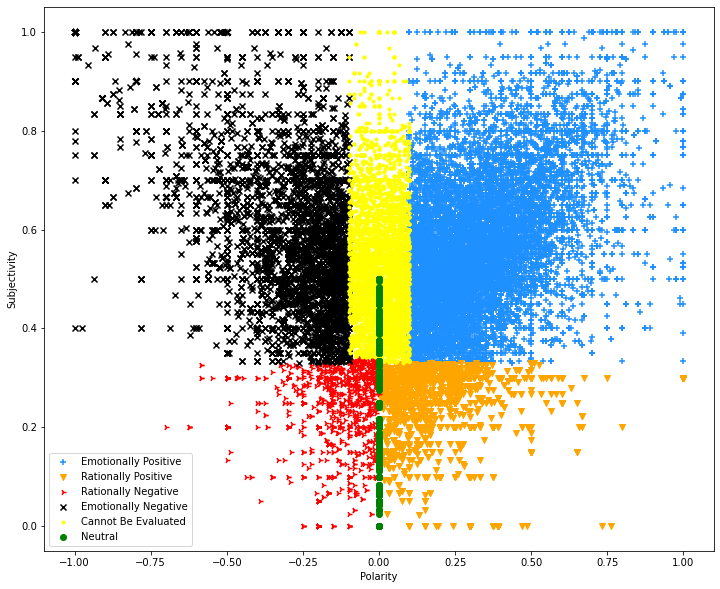

In [11]:
emPos=data[data['Category']=='Emotionally Positive']
raPos=data[data['Category']=='Rationally Positive']
neutral=data[data['Category']=='Neutral']
emNeg=data[data['Category']=='Rationally Negative']
raNeg=data[data['Category']=='Emotionally Negative']
NotValued = data[data['Category']=='Cannot Be Evaluated']


# PLOT
plt.figure(figsize=(12,10))
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.scatter(x=emPos.Sentiment_Polarity, y=emPos.Sentiment_Subjectivity,color='dodgerblue', marker= '+', label='Emotionally Positive')
plt.scatter(x=raPos.Sentiment_Polarity, y=raPos.Sentiment_Subjectivity,color= 'orange', marker='v', label='Rationally Positive')
plt.scatter(x=emNeg.Sentiment_Polarity, y=emNeg.Sentiment_Subjectivity,color= 'red', marker='4', label='Rationally Negative')
plt.scatter(x=raNeg.Sentiment_Polarity, y=raNeg.Sentiment_Subjectivity,color= 'black', marker='x', label='Emotionally Negative')
plt.scatter(x=NotValued.Sentiment_Polarity, y=NotValued.Sentiment_Subjectivity,color= 'yellow', marker='.', label='Cannot Be Evaluated')
plt.scatter(x=neutral.Sentiment_Polarity, y=neutral.Sentiment_Subjectivity,color= 'green', label='Neutral')
plt.legend()

* We can see the division pretty good, A graph of plotted points that show the relationship between two sets of data. 
* We can also see that the most of reviews are good, which is surprising to me.
* Most of the reviews are subjectively, It's normal because most of the reviewers have feeling and encounterd good or bad experience from those apps and that what motivated them to comment about it.
* I think that is the main reason that Emotionally positive is the larger group, Human kind have feeling and people want to be heard, that's why the Rationally emotions are a bit lesser than the emotionally groups.
* Although Neutral section is larger than all groups, except the Emotionally positive, The polarity has to be 0 in order to be Neutral. (That's why it's a line)

In [12]:
import re
from nltk.probability import FreqDist
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize,RegexpTokenizer
from nltk import FreqDist # Takes a bunch of tokens and returns the frequencies of all unique cases.
from nltk.corpus import stopwords
#data.shape (37427, 6)
data["index"] = range(0,37427)
data  = data.set_index("index")
data.head(10)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Category
index,,,,,,
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,Emotionally Positive
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,Rationally Positive
2,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000,Emotionally Positive
3,10 Best Foods for You,Best idea us,Positive,1.00,0.300000,Rationally Positive
4,10 Best Foods for You,Best way,Positive,1.00,0.300000,Rationally Positive
5,10 Best Foods for You,Amazing,Positive,0.60,0.900000,Emotionally Positive
6,10 Best Foods for You,"Looking forward app,",Neutral,0.00,0.000000,Neutral
7,10 Best Foods for You,It helpful site ! It help foods get !,Neutral,0.00,0.000000,Neutral
8,10 Best Foods for You,good you.,Positive,0.70,0.600000,Emotionally Positive


In [13]:
STOPWORDS = set(stopwords.words('english')) 

dfOld =data #save the old reviews for later use
tokenizer =RegexpTokenizer('\w+')
result = []
for i in range(0,37427):
    temp = re.sub('[^a-zA-Z]', ' ',data['Translated_Review'][i])
    temp = re.sub('[/(){}\[\]\|@!,;]', ' ',data['Translated_Review'][i]) #remove unnecessary symbols
    temp = temp.lower()#to lowercase
    temp = temp.split()# returns a list of strings after breaking the given string by the specified separator.
    temp = [token for token in temp if token not in STOPWORDS] 
    temp=' '.join(temp) #concat them with space
    result.append(temp) 
result

['like eat delicious food. that\'s i\'m cooking food case "10 best foods" helps lot also "best shelf life "',
 'help eating healthy exercise regular basis',
 'works great especially going grocery store',
 'best idea us',
 'best way',
 'amazing',
 'looking forward app',
 'helpful site help foods get',
 'good you.',
 'useful information amount spelling errors questions validity information shared. fixed 5 stars given.',
 'thank great app add arthritis eyes immunity kidney liver detox foods please. :',
 'greatest ever completely awesome maintain health.... must ppl there... love',
 'good health...... good health first priority.......',
 'health important world either life . think? :',
 'mrs sunita bhati thankful developers make kind app really good healthy food body',
 'useful diabetes age 30. need control sugar. thanks',
 'one greatest apps.',
 'good nice',
 'healthy really helped',
 'god health',
 'health always top priority. . mysg5.',
 'excellent useful',
 'found lot wealth form healt

In [14]:
text = []
for i in range(0,len(result)):
    text = text + (re.findall(r'\b\S+\b', result[i]))  #in order not to make it a list, just text
     
from collections import Counter
wordsCount = Counter(text) #all words and how many times they appeared in text
sortedWords = sorted(wordsCount.items(), key=lambda x: x[1], reverse=True)
wordList = []
CountList = []
for x, y in sortedWords: #run over sorted words and make two lists
    wordList.append(x)
    CountList.append(y)


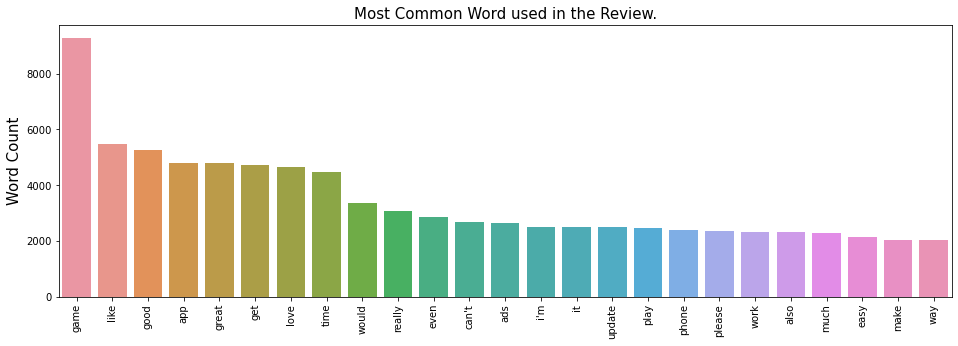

In [15]:
plt.figure(figsize=(16,5))
plot = sns.barplot(np.arange(25),CountList[0:25] )
plt.ylabel('Word Count',fontsize=15)
plt.xticks(np.arange(25), wordList[0:25], fontsize=10, rotation=90)
plt.title('Most Common Word used in the Review.', fontsize=15)
plt.show()

In [2]:
print('**Emotional Positive**\n')
print('Average polarity: ',emPos.Sentiment_Polarity.mean(), '\n Average Subjectivity:', emPos.Sentiment_Subjectivity.mean(),'\n')
print('**Rational Positive**\n')
print('Average polarity: ',raPos.Sentiment_Polarity.mean(), '\n Average Subjectivity:', raPos.Sentiment_Subjectivity.mean(),'\n')
print('**Neutral**\n')
print('Average polarity: ',neutral.Sentiment_Polarity.mean(), '\n Average Subjectivity:', neutral.Sentiment_Subjectivity.mean(),'\n')
print('**Emotional Negative**\n')
print('Average polarity: ',emNeg.Sentiment_Polarity.mean(), '\n Average Subjectivity:', emNeg.Sentiment_Subjectivity.mean(),'\n')
print('**Rational Negative**\n')
print('Average polarity: ',raNeg.Sentiment_Polarity.mean(), '\n Average Subjectivity:', raNeg.Sentiment_Subjectivity.mean(),'\n')





**Emotional Positive**



NameError: name 'emPos' is not defined

# Wordclouds:
- comparing between the "rational" and "emotional"

- Rational Positive

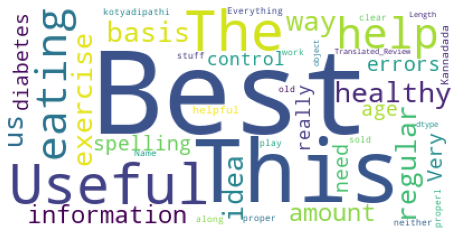

In [28]:
wordcloud = WordCloud( background_color ='white').generate(str(raPos['Translated_Review']))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.show()

- Emotional Positive

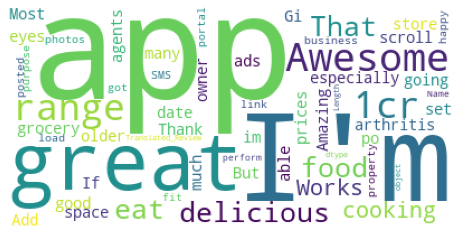

In [31]:
wordcloud = WordCloud( background_color ='white').generate(str(emPos['Translated_Review']))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.show()

- Rational Negative

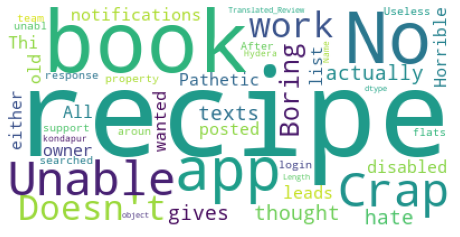

In [32]:
wordcloud = WordCloud( background_color ='white').generate(str(raNeg['Translated_Review']))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.show()

- Emotional Negative

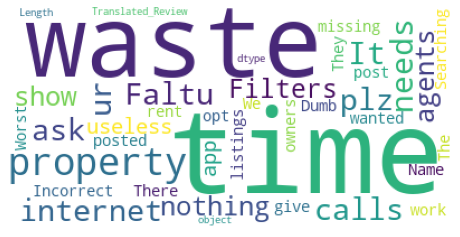

In [34]:
wordcloud = WordCloud( background_color ='white').generate(str(emNeg['Translated_Review']))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.show()

- We can see the big difference between the "rational" and the "Emotional" comments/reviews, in both of "Emotional" word cloud we see that a lot of word are depicting, like "waste" of time, "Awesome", "great", "usless" etc... while in the rational is not like that and a lot of the words are nouns like "recipe", "book","basis", etc...
- We can spot the difference between the Positive and the Negative reviews pretty easily, negative words(crap, no, dosent...) vs. positive words (great, best,usefull...)